In this notebook, I will attempt to use RNN models, such as SimpleRNN, LSTM and GRU, to classify days as those in which the price has increased (green candles) and those in which the price has decreased (red candles).

Let's start by introducing the functions.

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">create_dataset</span>
Creates a time-series dataset by windowing the data.

#### Parameters:
- X: Feature data
- y: Target data
- look_back (int): The window size for creating the dataset. Default is 1.

#### Returns:
- X_data: Windowed feature data
- y_data: Windowed target data

</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">RNN_Classification_Tester</span>

Trains a RNN (either LSTM or GRU) neural network for time series classification tasks.

### Parameters:
- df (DataFrame): DataFrame containing the data.
- rnn_type (str): Type of RNN to use ('SimpleRNN', 'LSTM' or 'GRU'). Default is 'LSTM'.
- look_back (int): Window size for the data. Default is 60.
- test_coef (int): Coefficient to determine test set size. Default is 10.
- val_coef (int): Coefficient to determine validation set size. Default is 4.
- dropout (float): Dropout rate for regularization. Default is 0.2.
- epochs (int): Number of training epochs. Default is 50.
- early_stopping (bool): If true, use early stopping during training. Default is True.
- num_layers (int): Number of RNN layers. Default is 2.
- units (int): Number of neurons in each RNN layer. Default is 50.
- optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
- activation_function (str): Activation function to use in RNN layers. Default is 'tanh'.
- batch_size (int): Size of each training batch. Default is 32.

### Returns:
- classifier: Trained RNN classification model
- X_test: Test feature data
- y_test: Test target data
- y_train_ratio: Ratio of positive samples in the training set
- elapsed_time: Time taken to train the classifier (in seconds, rounded to 2 decimal places)
- history: Training history object
    
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_loss_accuracy_classification</span>

Plots the training and validation loss and accuracy values for each epoch.

### Parameters:
- train_loss (list): Training loss values.
- train_accuracy (list): Training accuracy values.
- val_loss (list): Validation loss values.
- val_accuracy (list): Validation accuracy values.

### Returns:
- Displays a plot.
    
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_predictions</span>

Plots the training and validation loss and accuracy values for each epoch.

### Parameters:
- df (DataFrame): DataFrame containing the original data.
- predicted (list): Predicted values from the model.
- ticker (str): Stock ticker symbol.
- epochs (int): Number of training epochs. Default is False.
- elapsed_time (float): Time taken to train the model. Default is False.
- batch_size (int): Size of each training batch. Default is False.
- activation_function (str): Activation function for LSTM layers. Default is False.
- num_layers (int): Number of LSTM layers. Default is False.
- classification (bool): If true, indicates this is a classification task. Default is False.

### Returns:
- Displays a plot.
    
</div>

In [1]:
import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.html.table_schema', True)
display(HTML("<style>.rendered_html table { margin-left: auto; margin-right: auto; }</style>"))

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import time

from sklearn import preprocessing as pre
from sklearn import metrics as met

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, RMSprop

import yfinance as yf

def create_dataset(X, y, look_back=1):
    
    """
    Creates a time-series dataset by windowing the data.
    
    Parameters:
    - X: Feature data
    - y: Target data
    - look_back (int): The window size for creating the dataset. Default is 1.
    
    Returns:
    - X_data: Windowed feature data
    - y_data: Windowed target data
    """
    
    X_data, y_data = [], []
    for i in range(len(X) - look_back):
        X_data.append(X[i:(i + look_back)])
        y_data.append(y[i + look_back])
    return np.array(X_data), np.array(y_data)

def RNN_Classification_Tester(df, target, rnn_type='LSTM', look_back=60, test_coef=10, val_coef=4, dropout=0.2, epochs=50, early_stopping=True, num_layers=2, units=50, optimizer='rmsprop', activation_function='tanh', batch_size=32, reduce_learning = True):

    """
    Trains a RNN (LSTM, GRU, SimpleRNN) neural network for time series classification tasks.
    
    Parameters:
    - df (DataFrame): DataFrame containing the data.
    - target (str): Name of the target column.
    - rnn_type (str): Type of RNN to use ('LSTM', 'GRU', 'SimpleRNN'). Default is 'LSTM'.
    - look_back (int): Window size for the data. Default is 60.
    - test_coef (int): Coefficient to determine test set size. Default is 10.
    - val_coef (int): Coefficient to determine validation set size. Default is 4.
    - dropout (float): Dropout rate for regularization. Default is 0.2.
    - epochs (int): Number of training epochs. Default is 50.
    - early_stopping (bool): If true, use early stopping during training. Default is True.
    - num_layers (int): Number of RNN layers. Default is 2.
    - units (int): Number of neurons in each RNN layer. Default is 50.
    - optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
    - activation_function (str): Activation function to use in RNN layers. Default is 'tanh'.
    - batch_size (int): Size of each training batch. Default is 32.
    
    Returns:
    - classifier: Trained RNN classification model
    - X_test: Test feature data
    - y_test: Test target data
    - y_train_ratio: Ratio of positive samples in the training set
    - elapsed_time: Time taken to train the classifier (in seconds, rounded to 2 decimal places)
    - history: Training history object
    
    Notes:
    -----
    classifier, X_test, y_test, y_train_ratio, elapsed_time, history = RNN_Classification_Tester(df = test_df,
                                                                                                rnn_type = rnn_type,
                                                                                                look_back = look_back,
                                                                                                test_coef = test_coef,
                                                                                                val_coef = val_coef,
                                                                                                dropout = dropout,
                                                                                                epochs = epoch,
                                                                                                num_layers=num_layers,
                                                                                                activation_function=activation_function,
                                                                                                batch_size = batch_size)
    """
    
    start_time = time.time()
    
    X = df.drop(target, axis = 1).values
    
    if len(df.columns) > 1:
        n_cols = X.shape[1]
    else:
        n_cols = 1

    y = df[target].values

    X_val, X_test = X[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], X[-2 * look_back * test_coef:]
    y_val, y_test = y[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], y[-2 * look_back * test_coef:]

    X_train, y_train = X[:-1 * (len(X_val) + len(X_test))], y[:-1 * (len(X_val) + len(X_test))]
    
    y_train_ratio = sum(y_train) / len(y_train)
    
    scaler_X = pre.MinMaxScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    
    X_train, y_train = create_dataset(X_train, y_train, look_back)
    X_val, y_val = create_dataset(X_val, y_val, look_back)
    X_test, y_test = create_dataset(X_test, y_test, look_back)

    classifier = Sequential()

    if rnn_type == 'LSTM':
        RNNLayer = LSTM
    elif rnn_type == 'GRU':
        RNNLayer = GRU
    elif rnn_type == 'SimpleRNN':
        RNNLayer = SimpleRNN
    else:
        raise ValueError("Invalid RNN Type. Expected 'LSTM', 'GRU' or 'SimpleRNN'")
        
    classifier.add(RNNLayer(units=units, activation=activation_function, return_sequences=True, input_shape=(X_train.shape[1], n_cols)))
    classifier.add(Dropout(dropout))
    
    for layer in range(num_layers - 1):
        classifier.add(RNNLayer(units=units, activation=activation_function, return_sequences=True if layer < num_layers - 2 else False))
        classifier.add(Dropout(dropout))

    classifier.add(Dense(units=1, activation='sigmoid'))

    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks_list = []

    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, restore_best_weights=True)
        callbacks_list.append(early_stop)
    if reduce_learning:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, min_delta=0.001)
        callbacks_list.append(reduce_lr)

    history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return classifier, X_test, y_test, y_train_ratio, round(elapsed_time, 2), history

def classification_results(epochs, elapsed_time, train_loss, train_accuracy, val_loss, val_accuracy, y_test, predicted_labels):
    
    """
    Generates a DataFrame containing classification results.
    
    Parameters:
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - train_loss (float): Loss value on the training set.
    - train_accuracy (float): Accuracy on the training set.
    - val_loss (float): Loss value on the validation set.
    - val_accuracy (float): Accuracy on the validation set.
    - y_test (array-like): True target values for test set.
    - predicted_labels (array-like): Predicted values for test set.
    
    Returns:
    - df (DataFrame): DataFrame with classification metrics.
    
    Notes:
    -----
    
    display(classification_results(epochs = epoch, 
                                   elapsed_time = elapsed_time, 
                                   train_loss = history.history['loss'], 
                                   train_accuracy = history.history['accuracy'], 
                                   val_loss = history.history['val_loss'], 
                                   val_accuracy = history.history['val_accuracy'], 
                                   y_test = y_test, 
                                   predicted_labels = predicted_labels).style.hide()
    """
    
    test_accuracy = round(met.accuracy_score(y_test, predicted_labels), 2)
    df = pd.DataFrame({"epochs": [epochs], "epochs completed": [len(train_loss)], "elapsed time": [round(elapsed_time, 2)], "test accuracy": [test_accuracy],\
                       "min train loss": [min(train_loss)], "min validation loss": [min(val_loss)],\
                       "max train accuracy": [max(train_accuracy)], "max validation accuracy": [max(val_accuracy)]})
    return df

def plot_loss_accuracy_classification(train_loss, train_accuracy, val_loss, val_accuracy):
    
    """
    Plots the training and validation loss and accuracy values for each epoch.
    
    Parameters:
    - train_loss (list): Training loss values.
    - train_accuracy (list): Training accuracy values.
    - val_loss (list): Validation loss values.
    - val_accuracy (list): Validation accuracy values.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_loss_accuracy_classification(train_loss = history.history['loss'],
                                      train_accuracy = history.history['accuracy'],
                                      val_loss = history.history['val_loss'], 
                                      val_accuracy = history.history['val_accuracy'])
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].plot(train_loss, color='b', label='Training Loss')
    axs[0].plot(val_loss, color='r', label='Validation Loss')
    axs[0].set_title("Loss curves")
    axs[0].legend(loc='best', shadow=True)
    axs[1].plot(train_accuracy, color='b', label='Training Accuracy')
    axs[1].plot(val_accuracy, color='r', label='Validation Accuracy')
    axs[1].set_title("Accuracy curves")
    axs[1].legend(loc='best', shadow=True)
    plt.show()
    
def plot_predictions(df, predicted, ticker, rnn_type = False, dropout = False, epochs = False, num_layers = False, activation_function = False, batch_size = False, elapsed_time = False, classification = False, line = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_predictions(df = df,
                     predicted = predicted_price_NASDAQ_LSTM,
                     ticker = ticker,
                     rnn_type = rnn_type,
                     dropout = dropout,
                     epochs = epoch,
                     num_layers=num_layers,
                     activation_function=activation_function,
                     batch_size = batch_size,
                     elapsed_time = elapsed_time,
                     classification = False,
                     line = False)
    
    """
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    if line:
        ax.plot(bar_df.index, bar_df["Close"], color='red', label=f'{ticker} Closing Price', linewidth=1, marker = "o")
    else:
        color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df["Close"], bar_df["Open"])]
        candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
        ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    if classification:
        actual = (df["Close"].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        if line:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} Closing Price', linewidth=1, marker = "o")
        else:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} Closing Price', linewidth=1)
    ax.legend()
    
    title = []
    if epochs:
        title.append(f'# of Epochs: {epochs}, ')
    if elapsed_time:
        title.append(f'Computation Time: {elapsed_time} Seconds, ')
    if batch_size:
        title.append(f'Batch Size: {batch_size}, ')
    if activation_function:
        title.append(f'Activation Function: {activation_function}, ')
    if num_layers:
        title.append(f'# of Layers: {num_layers}, Dropout: {dropout}, ')
    if rnn_type:
        title.append(f'RNN Type: {rnn_type}, ')

    if len(title) > 0:
        title = ''.join(title)[:-2]
    else:
        title = ticker

    ax.set_title(title , fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} Closing Price')
    plt.tight_layout()
    plt.show()

Now, I will download the historical prices of the NASDAQ Composite Index to test the performance of the code.

In [2]:
explanations = []

nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-25 00:00:00-04:00,13514.370117,13633.419922,13376.349609,13590.650391,3970060000,0.0,0.0
2023-08-28 00:00:00-04:00,13695.360352,13735.980469,13626.639648,13705.129883,3666680000,0.0,0.0
2023-08-29 00:00:00-04:00,13687.230469,13959.809570,13677.059570,13943.759766,4748180000,0.0,0.0
2023-08-30 00:00:00-04:00,13961.769531,14050.820312,13924.200195,14019.309570,4364600000,0.0,0.0
2023-08-31 00:00:00-04:00,14041.500000,14114.674805,14039.190430,14065.783203,1450471000,0.0,0.0


### Classification model to predict NASDAQ Close Price using SimpleRNN

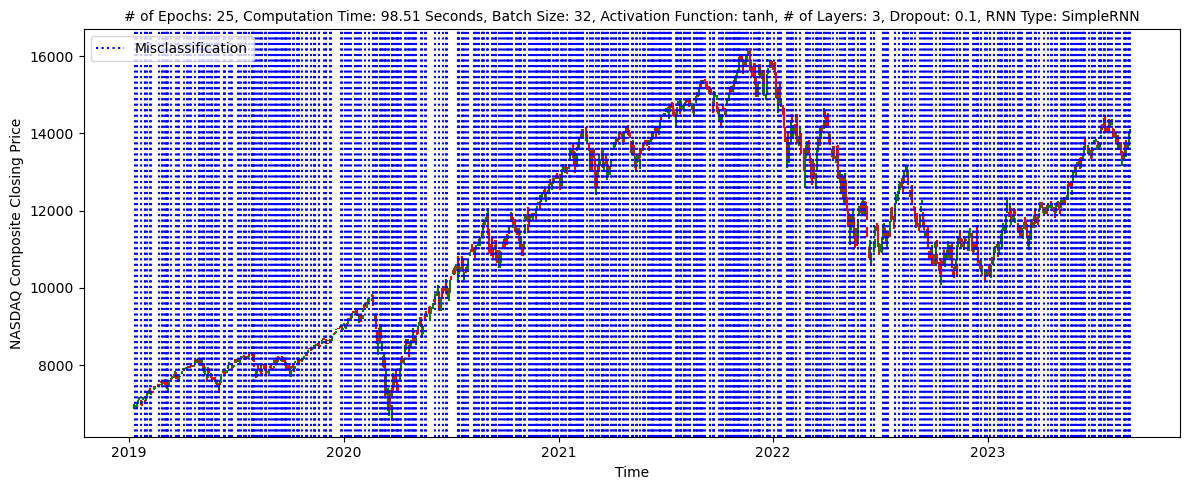

epochs,epochs completed,elapsed time,test accuracy,min train loss,min validation loss,max train accuracy,max validation accuracy
25,16,98.510000,0.520000,0.686110,0.687010,0.557721,0.554701


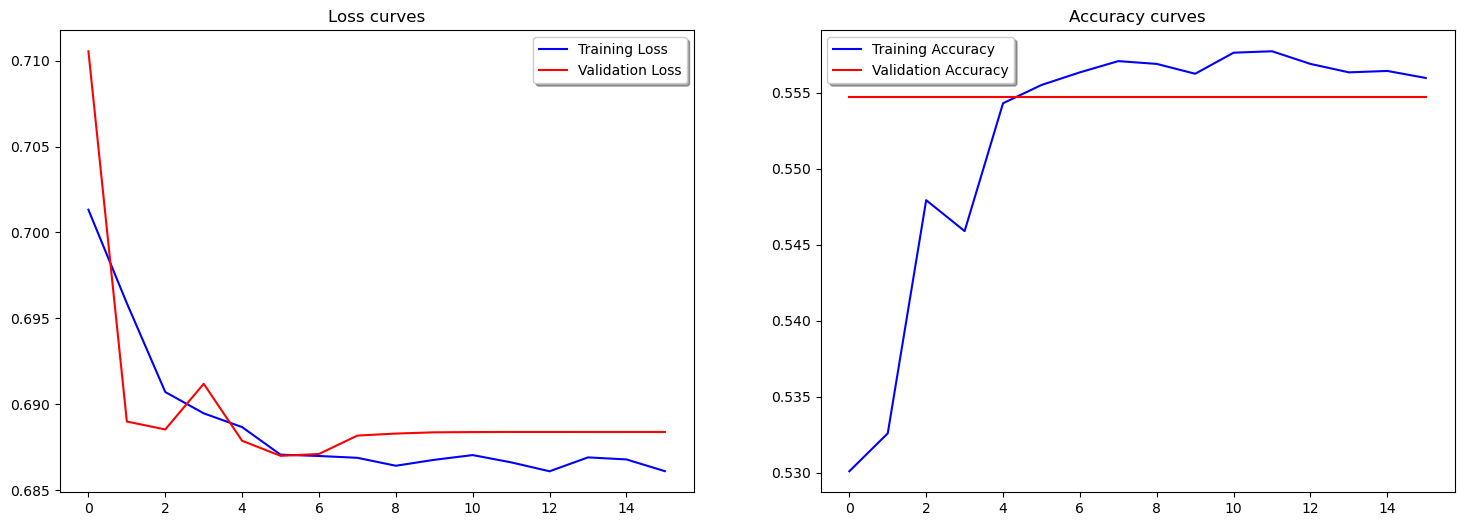

In [4]:
df_NASDAQ["Target"] = (df_NASDAQ[["Close"]].pct_change()>0).astype(int).values
test_df = df_NASDAQ[["Close", "Target"]]

rnn_type='SimpleRNN'
num_layers = 3 
activation_function = "tanh"
optimizer = RMSprop(learning_rate=0.1)
dropout = 0.1
units = 50
epoch = 25

batch_size = 32

look_back = 30
test_coef = 20
val_coef = 4
target = "Target"
ticker = "NASDAQ Composite"

classifier, X_test, y_test, y_train_ratio, elapsed_time, history = RNN_Classification_Tester(df = test_df,
                                                                                             target = target,
                                                                                             rnn_type = rnn_type,
                                                                                             look_back = look_back,
                                                                                             test_coef = test_coef,
                                                                                             val_coef = val_coef,
                                                                                             dropout = dropout,
                                                                                             epochs = epoch,
                                                                                             num_layers=num_layers,
                                                                                             activation_function=activation_function,
                                                                                             batch_size = batch_size)
predicted_labels = classifier.predict(X_test, verbose = 0)
predicted_labels_NASDAQ_SimpleRNN = (predicted_labels > np.percentile(predicted_labels, y_train_ratio*100)).astype(int).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_labels_NASDAQ_SimpleRNN,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time,
                 classification=True)

SimpleRNN_NASDAQ = classification_results(epochs = epoch, 
                                           elapsed_time = elapsed_time, 
                                           train_loss = history.history['loss'], 
                                           train_accuracy = history.history['accuracy'], 
                                           val_loss = history.history['val_loss'], 
                                           val_accuracy = history.history['val_accuracy'], 
                                           y_test = y_test, 
                                           predicted_labels = predicted_labels_NASDAQ_SimpleRNN)

display(SimpleRNN_NASDAQ.style.hide())

plot_loss_accuracy_classification(train_loss = history.history['loss'],
                                  train_accuracy = history.history['accuracy'],
                                  val_loss = history.history['val_loss'], 
                                  val_accuracy = history.history['val_accuracy'])

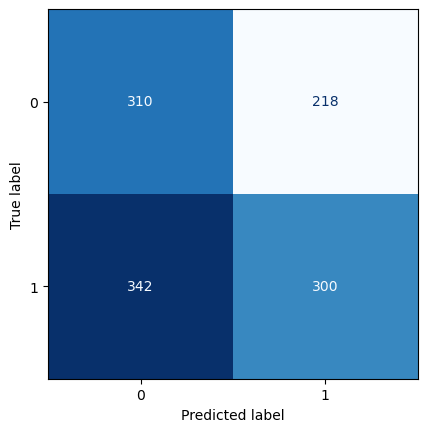

In [8]:
func_list = ["SimpleRNN"]

cf_matrix = met.confusion_matrix(y_test, predicted_labels_NASDAQ_SimpleRNN)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, predicted_labels_NASDAQ_SimpleRNN)
func_list.append(accuracy)
precision = met.precision_score(y_test, predicted_labels_NASDAQ_SimpleRNN)
func_list.append(precision)
recall = met.recall_score(y_test, predicted_labels_NASDAQ_SimpleRNN)
func_list.append(recall)
f1 = met.f1_score(y_test, predicted_labels_NASDAQ_SimpleRNN)
func_list.append(f1)

func_list.append(predicted_labels_NASDAQ_SimpleRNN)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

### Classification model to predict NASDAQ Close Price using LSTM

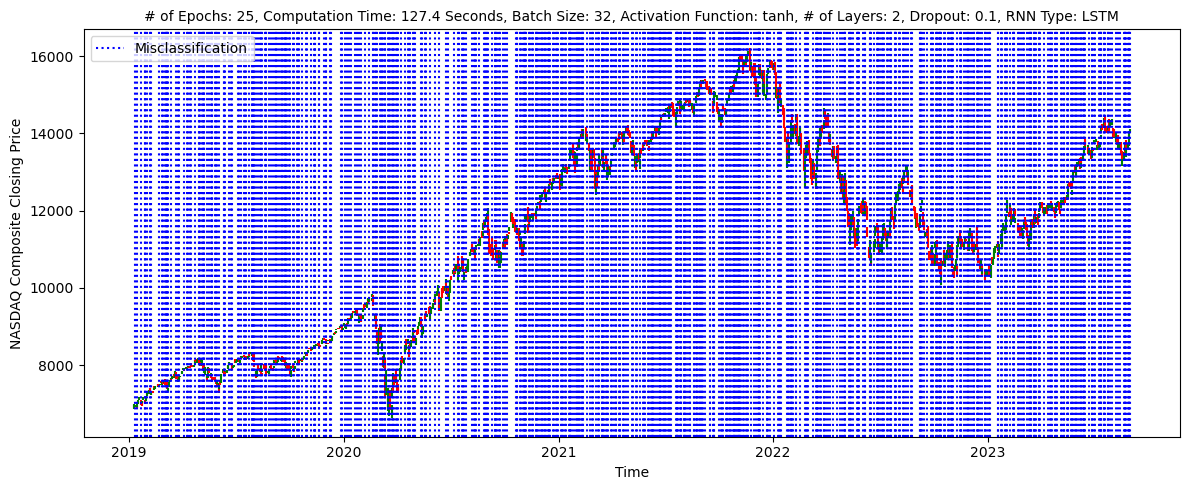

epochs,epochs completed,elapsed time,test accuracy,min train loss,min validation loss,max train accuracy,max validation accuracy
25,13,127.400000,0.520000,0.686356,0.688348,0.557167,0.556410


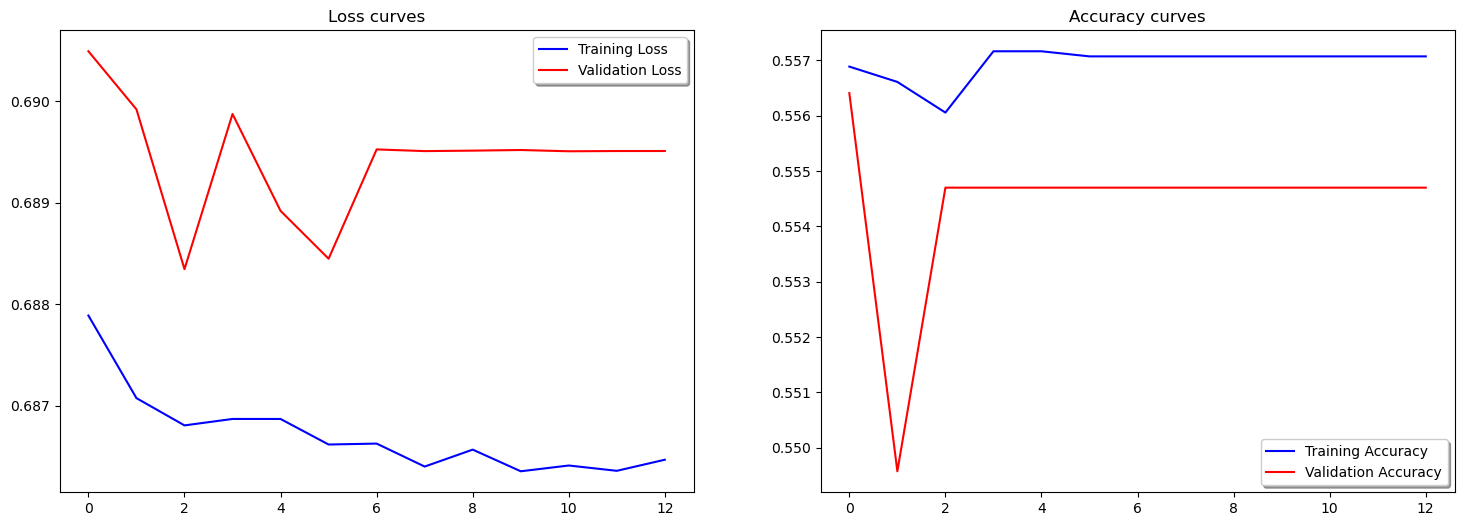

In [9]:
rnn_type='LSTM'
num_layers = 2 
activation_function = "tanh"
optimizer = RMSprop(learning_rate=1)
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

target = "Target"
ticker = "NASDAQ Composite"

classifier, X_test, y_test, y_train_ratio, elapsed_time, history = RNN_Classification_Tester(df = test_df,
                                                                                             target = target,
                                                                                             rnn_type = rnn_type,
                                                                                             look_back = look_back,
                                                                                             test_coef = test_coef,
                                                                                             val_coef = val_coef,
                                                                                             dropout = dropout,
                                                                                             epochs = epoch,
                                                                                             num_layers=num_layers,
                                                                                             activation_function=activation_function,
                                                                                             batch_size = batch_size)
predicted_labels = classifier.predict(X_test, verbose = 0)
predicted_labels_NASDAQ_LSTM = (predicted_labels > np.percentile(predicted_labels, y_train_ratio*100)).astype(int).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_labels_NASDAQ_LSTM,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time,
                 classification=True)

LSTM_NASDAQ = classification_results(epochs = epoch, 
                                           elapsed_time = elapsed_time, 
                                           train_loss = history.history['loss'], 
                                           train_accuracy = history.history['accuracy'], 
                                           val_loss = history.history['val_loss'], 
                                           val_accuracy = history.history['val_accuracy'], 
                                           y_test = y_test, 
                                           predicted_labels = predicted_labels_NASDAQ_LSTM)

display(LSTM_NASDAQ.style.hide())

plot_loss_accuracy_classification(train_loss = history.history['loss'],
                                  train_accuracy = history.history['accuracy'],
                                  val_loss = history.history['val_loss'], 
                                  val_accuracy = history.history['val_accuracy'])

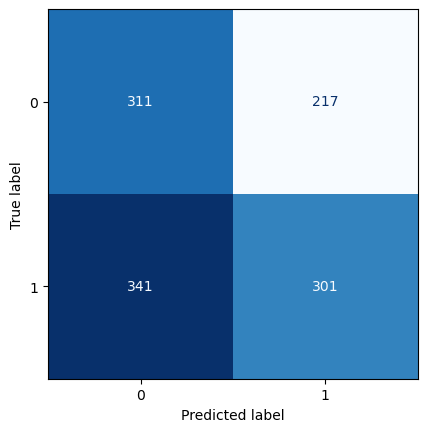

In [10]:
func_list = ["LSTM"]

cf_matrix = met.confusion_matrix(y_test, predicted_labels_NASDAQ_LSTM)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, predicted_labels_NASDAQ_LSTM)
func_list.append(accuracy)
precision = met.precision_score(y_test, predicted_labels_NASDAQ_LSTM)
func_list.append(precision)
recall = met.recall_score(y_test, predicted_labels_NASDAQ_LSTM)
func_list.append(recall)
f1 = met.f1_score(y_test, predicted_labels_NASDAQ_LSTM)
func_list.append(f1)

func_list.append(predicted_labels_NASDAQ_LSTM)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

### Classification model to predict NASDAQ Close Price using GRU

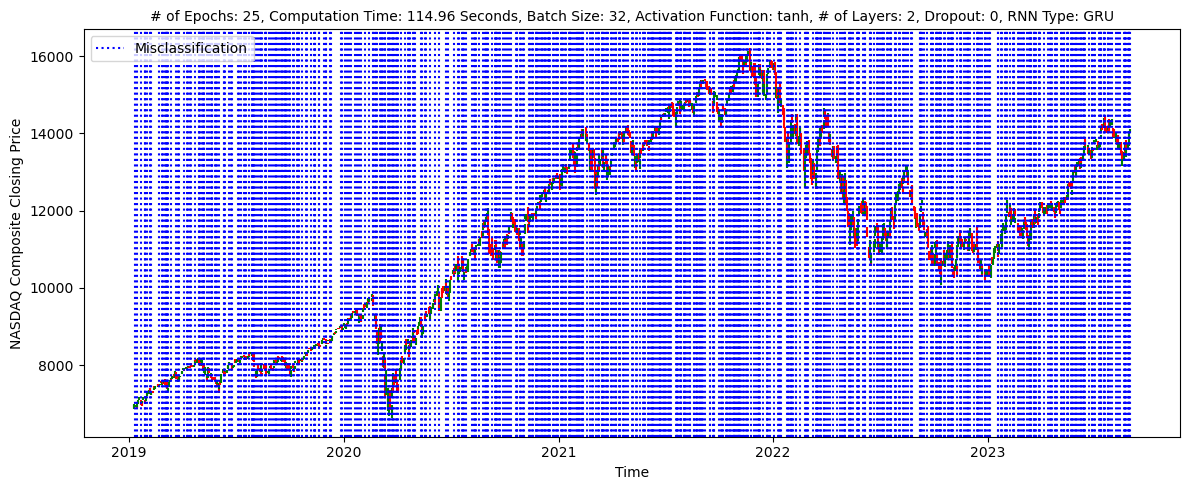

epochs,epochs completed,elapsed time,test accuracy,min train loss,min validation loss,max train accuracy,max validation accuracy
25,11,114.960000,0.530000,0.686363,0.687177,0.557074,0.555556


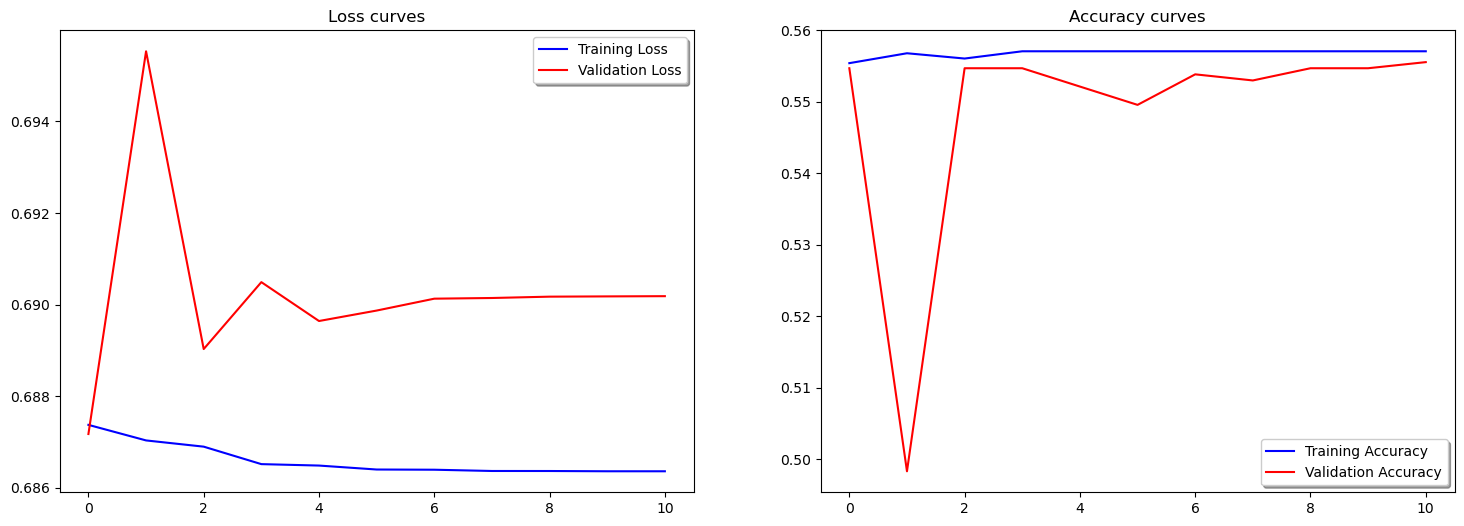

In [11]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = RMSprop(learning_rate=0.1)
dropout = 0
units = 50
epoch = 25
batch_size = 32

target = "Target"
ticker = "NASDAQ Composite"

classifier, X_test, y_test, y_train_ratio, elapsed_time, history = RNN_Classification_Tester(df = test_df,
                                                                                             target = target,
                                                                                             rnn_type = rnn_type,
                                                                                             look_back = look_back,
                                                                                             test_coef = test_coef,
                                                                                             val_coef = val_coef,
                                                                                             dropout = dropout,
                                                                                             epochs = epoch,
                                                                                             num_layers=num_layers,
                                                                                             activation_function=activation_function,
                                                                                             batch_size = batch_size)
predicted_labels = classifier.predict(X_test, verbose = 0)
predicted_labels_NASDAQ_GRU = (predicted_labels > np.percentile(predicted_labels, y_train_ratio*100)).astype(int).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_labels_NASDAQ_GRU,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time,
                 classification=True)

GRU_NASDAQ = classification_results(epochs = epoch, 
                                           elapsed_time = elapsed_time, 
                                           train_loss = history.history['loss'], 
                                           train_accuracy = history.history['accuracy'], 
                                           val_loss = history.history['val_loss'], 
                                           val_accuracy = history.history['val_accuracy'], 
                                           y_test = y_test, 
                                           predicted_labels = predicted_labels_NASDAQ_GRU)

display(GRU_NASDAQ.style.hide())

plot_loss_accuracy_classification(train_loss = history.history['loss'],
                                  train_accuracy = history.history['accuracy'],
                                  val_loss = history.history['val_loss'], 
                                  val_accuracy = history.history['val_accuracy'])

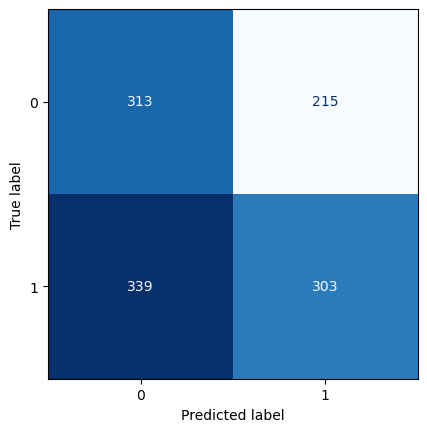

In [12]:
func_list = ["GRU"]

cf_matrix = met.confusion_matrix(y_test, predicted_labels_NASDAQ_GRU)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(accuracy)
precision = met.precision_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(precision)
recall = met.recall_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(recall)
f1 = met.f1_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(f1)

func_list.append(predicted_labels_NASDAQ_GRU)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [26]:
df_results_base = pd.DataFrame(explanations, columns=["Model", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1", "Y_Pred"])
df_results_base.set_index("Model", inplace = True)
df_results_base.iloc[:, :-1]

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1
Model,,,,,,,,
SimpleRNN,310,218,342,300,0.521368,0.579151,0.467290,0.517241
LSTM,311,217,341,301,0.523077,0.581081,0.468847,0.518966
GRU,313,215,339,303,0.526496,0.584942,0.471963,0.522414
Naive Predictions,313,215,339,303,0.526496,0.584942,0.471963,0.522414


## Bummer!!

It seems that the classification model doesn't perform very well. Let's evaluate the performance of a naive model, as we did in the previous notebook. According to this naive approach, if the price increased yesterday, we predict it will continue to rise; otherwise, we expect it to decrease.

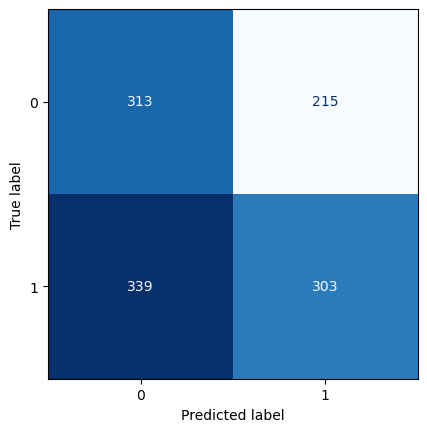

In [27]:
naive_NASDAQ = (df_NASDAQ.Close.shift(-1).pct_change() > 0).astype(int)[-len(y_test):]

func_list = ["Naive Predictions"]

cf_matrix = met.confusion_matrix(y_test, predicted_labels_NASDAQ_GRU)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(accuracy)
precision = met.precision_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(precision)
recall = met.recall_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(recall)
f1 = met.f1_score(y_test, predicted_labels_NASDAQ_GRU)
func_list.append(f1)

func_list.append(predicted_labels_NASDAQ_GRU)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

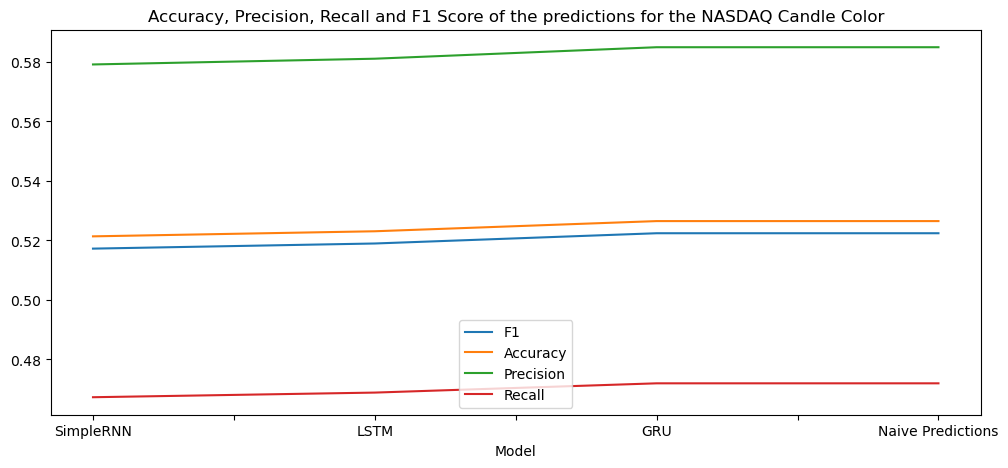

In [28]:
df_results_base[["F1", "Accuracy", "Precision","Recall"]].plot(figsize = (12,5))
plt.title("Accuracy, Precision, Recall and F1 Score of the predictions for the NASDAQ Candle Color")
plt.show()

In [30]:
df_results_base = pd.DataFrame(explanations, columns=["Model", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1", "Y_Pred"])
df_results_base.set_index("Model", inplace = True)
df_results_base.iloc[:, :-1]

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1
Model,,,,,,,,
SimpleRNN,310,218,342,300,0.521368,0.579151,0.467290,0.517241
LSTM,311,217,341,301,0.523077,0.581081,0.468847,0.518966
GRU,313,215,339,303,0.526496,0.584942,0.471963,0.522414
Naive Predictions,313,215,339,303,0.526496,0.584942,0.471963,0.522414
Naive Predictions,313,215,339,303,0.526496,0.584942,0.471963,0.522414


## What have we learned?

- The GRU outperforms both LSTM and SimpleRNN in regression tasks. However, surprisingly, a naive prediction method surpasses all of them.
- Using just the closing price to predict whether the price is going to increase or not isn't really effective.

## What's next?

- I plan to enhance the dataset by introducing technical indicators. Moreover, I aim to incorporate independent indices, such as the VIX, DJI, etc., to enrich the model's input data.
- I'm also keen to delve into traditional time series models like ARIMA to compare their predictive abilities against RNN models.
- After an exhaustive exploration and optimization process for index predictions, I will pivot to forecasting individual stock prices.